### Input

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from joblib import dump, load
import pickle
import copy
import gc
import os

import nue_selection_helper as nue_helper

pd.set_option("display.max_columns", 500)

### Constants

In [3]:
write_pickle = False
input_dir = "./input/Jun2020/"
output_dir = "./output/"
plot_samples = {"dirt", "sideband", "on", "nu", "off"}

In [4]:
if write_pickle:
    # Load Samples, takes a minute or two
    nue_helper.CreateAfterTraining(plot_samples, input_dir, one_file=True)

Finished on (beam_on_slimmed.pckl), took 0.9 seconds.
Selected 19/185125 events, 0.010%

5    74005
Name: category, dtype: int64
Finished dirt (dirt_slimmed.pckl), took 1.8 seconds.
Selected 3/208399 events, 0.001%

Finished sideband (beam_sideband_slimmed.pckl), took 1.2 seconds.
Selected 180/31772 events, 0.567%

2     2288610
5     1265547
21     767561
3      592254
4      383335
1      209801
11     175422
31     138567
10      28305
Name: category, dtype: int64
Finished nu (nu_new_slimmed.pckl), took 82.0 seconds.
Selected 29233/3429281 events, 0.852%

Finished off (beam_off_slimmed.pckl), took 3.3 seconds.
Selected 63/3330343 events, 0.002%



In [5]:
retrain = False
train_ana = False
seed = 7
test_size = 0.05
lee_focus = 1.0
train_sample = "train_new"

### Load Samples

In [6]:
%%time
train = pd.read_pickle(input_dir+"{}_slimmed.pckl".format(train_sample))

available_samples = os.listdir(input_dir)
print(available_samples)
all_samples = {
    s: pd.read_pickle(input_dir+min([f for f in available_samples if s in f], key=len)) for s in plot_samples
}
all_samples['train'] = train

['nu_new_slimmed.pckl', 'train_new_slimmed.pckl', 'beam_sideband_slimmed.pckl', 'beam_on_slimmed.pckl', 'lite', 'dirt_slimmed.pckl', 'beam_off_slimmed.pckl']
CPU times: user 4.25 s, sys: 10.5 s, total: 14.8 s
Wall time: 19.6 s


In [7]:
# Add fields and perform preselection
for sample, data in all_samples.items():
    print(sample)
    if sample in nue_helper.helper.data_samples:
        data["daughters"]["optical_filter"] = True
    else:
        # We do not need weights in the training
        for w in nue_helper.helper.syst_weights:
            data["mc"][w] = None
        if sample == "dirt":
            nue_helper.FixDirtWeights(data["mc"], sum(data["pot"].values()))
        nue_helper.AddSimulatedFields(sample, data)

    if sample == "sideband":
        nue_helper.FixSidebandRuns(data["daughters"])

    nue_helper.AddRecoFields(data["daughters"])
    nue_helper.AddOtherDaughterAngleDiff(data["daughters"])
    nue_helper.PrepareTraining(data["daughters"])

on
sideband
nu
off
dirt
train
Truth field event_scale is not in sample train


In [8]:
print("Training set constructed with {} entries.".format(train["numentries"]))

Training set constructed with 2743560 entries.


### Explore Tree

In [9]:
train["daughters"].keys()

Index(['n_showers', 'evt', 'backtracked_start_x', 'hits_ratio',
       'shr_tkfit_nhits_v', 'reco_nu_vtx_sce_z', 'pfp_generation_v',
       'backtracked_start_y', 'backtracked_pdg', 'trk_theta_v',
       'shr_tkfit_2cm_dedx_Y', 'shr_energy_y_v', 'backtracked_px',
       'shr_tkfit_2cm_nhits_Y', 'shr_phi_v', 'NeutrinoEnergy2',
       'contained_fraction', 'CosmicDirAll3D', 'trk_sce_end_x_v',
       'SliceCaloEnergy2', 'pfp_trk_daughters_v', 'n_pfps', 'trk_score_v',
       'shr_tkfit_dedx_nhits_y_v', 'trk_len_v', 'reco_nu_vtx_x',
       'backtracked_completeness', 'trk_llr_pid_score_v', 'trk_sce_start_x_v',
       'topological_score', 'pfnhits', 'shr_tkfit_gap10_dedx_y_v',
       'backtracked_overlay_purity', 'reco_nu_vtx_y', 'trk_phi_v',
       'n_showers_contained', 'run', 'slpdg', 'backtracked_e',
       'reco_nu_vtx_sce_y', 'shr_tkfit_dedx_y_v', 'trk_sce_start_y_v',
       'shr_moliere_avg_v', 'merge_bestdist', 'trk_sce_start_z_v',
       'merge_bestdot', 'n_tracks', 'shr_theta_v', '

In [10]:
train["mc"].keys()

dict_keys(['nu_e', 'nu_pdg', 'nu_purity_from_pfp', 'true_nu_vtx_z', 'mc_pdg', 'leeweight', 'true_nu_vtx_y', 'mc_E', 'interaction', 'nproton', 'ccnc', 'n_pfps', 'true_nu_vtx_x', 'theta', 'nelec', 'weightSpline', 'nmuon', 'lep_e', 'nu_completeness_from_pfp', 'weightSplineTimesTune', 'npi0', 'npion', 'nueccinc', 'Run', 'sample', 'filter', 'optical_filter', 'weightsFlux', 'weightsGenie', 'weightSplineTimesTune_pi0scaled'])

### Provide the correct scaling

In [11]:
pot_scale = all_samples["on"]["pot"] / nue_helper.pot_target

### Shower dE/dx comparison

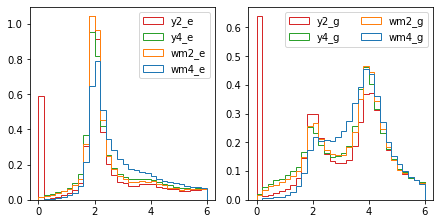

In [12]:
e_q = "backtracked_pdg==11 & backtracked_completeness>0.7 & trk_score_v <0.3 & shr_energy_y_v>100 & reco_fid_vol & shr_tkfit_dedx_nhits_y_v>0 & shr_tkfit_2cm_nhits_Y>0"
g_q = "backtracked_pdg==22 & backtracked_completeness>0.7 & trk_score_v <0.3 & shr_energy_y_v>100 & reco_fid_vol & shr_tkfit_dedx_nhits_y_v>0 & shr_tkfit_2cm_nhits_Y>0"

wm4_e = all_samples["nu"]["daughters"].query(e_q)["shr_tkfit_4cm_dedx_wm_v"]
wm4_g = all_samples["nu"]["daughters"].query(g_q)["shr_tkfit_4cm_dedx_wm_v"]
#wm2_e = all_samples["nu"]["daughters"].query(e_q)["shr_tkfit_2cm_dedx_wm_v"]
#wm2_g = all_samples["nu"]["daughters"].query(g_q)["shr_tkfit_2cm_dedx_wm_v"]
y4_e = all_samples["nu"]["daughters"].query(e_q)["shr_tkfit_dedx_y_v"]
y4_g = all_samples["nu"]["daughters"].query(g_q)["shr_tkfit_dedx_y_v"]
y2_e = all_samples["nu"]["daughters"].query(e_q)["shr_tkfit_2cm_dedx_Y"]
y2_g = all_samples["nu"]["daughters"].query(g_q)["shr_tkfit_2cm_dedx_Y"]
y_gap_e = all_samples["nu"]["daughters"].query(e_q)["shr_tkfit_gap10_dedx_y_v"]
y_gap_g = all_samples["nu"]["daughters"].query(g_q)["shr_tkfit_gap10_dedx_y_v"]

fig, ax = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(6, 3))
ax[0].hist(
    [wm4_e, y4_e, y2_e, y_gap_e],
    label=["wm4_e", "wm2_e", "y4_e", "y2_e", "y_gap_e"],
    range=(0, 6),
    bins=30,
    histtype="step",
    density=1,
)
ax[0].legend()

ax[1].hist(
    [wm4_g, y4_g, y2_g, y_gap_g],
    label=["wm4_g", "wm2_g", "y4_g", "y2_g", "y_gap_g"],
    range=(0, 6),
    bins=30,
    histtype="step",
    density=1,
)
ax[1].legend(ncol=2)

In [13]:
%%time
# Add training labels and weights
e_cand = train["daughters"]['e_candidate']
e_good = train["daughters"].eval('e_candidate & abs(backtracked_pdg)==11 & backtracked_purity>0.8 & backtracked_completeness>0.8 & true_vtx_distance<5')
e_cand_bad = train["daughters"].eval('e_candidate & abs(backtracked_pdg)!=11') 
other_bad = train["daughters"].eval('~e_candidate & (abs(backtracked_pdg)==13 | backtracked_pdg==0)')
other_neutral = train["daughters"].eval('~e_candidate & (backtracked_pdg==22 | abs(backtracked_pdg)==211)')
train["daughters"]['train_weight'] = train["daughters"].eval('weightSplineTimesTune+leeweight*@lee_focus') # weight low energy electrons a bit higher
train["daughters"]['train_weight'] = train["daughters"].eval('train_weight*(1+(shr_energy_y_v<600)*@lee_focus*e_candidate)') # weight low energy electrons a bit higher
train["daughters"].loc[e_good, "train_weight"] *= 2 # can be tuned
train["daughters"].loc[other_neutral, "train_weight"] = 1 # can be tuned

train["daughters"]['train_label'] = 1
train["daughters"].loc[e_cand_bad, "train_label"] = 0
train["daughters"].loc[other_bad, "train_label"] = 0
train["daughters"].loc[other_neutral, "train_label"] = 0

CPU times: user 1.12 s, sys: 329 ms, total: 1.45 s
Wall time: 1.5 s


In [14]:
gc.collect

<function gc.collect(generation=2)>

In [15]:
# What is the POT scaling before any cuts, after sliceID?
pass_nu = (
    all_samples["nu"]["daughters"]
    .xs(0, level="daughter")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_dirt = (
    all_samples["dirt"]["daughters"]
    .xs(0, level="daughter")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_off = (
    len(all_samples["off"]["daughters"].xs(0, level="daughter"))
    * all_samples["off"]["scaling"]
)
pass_on = (
    len(all_samples["on"]["daughters"].xs(0, level="daughter"))
    * all_samples["on"]["scaling"]
)
print("data/MC: {:.3f}".format((pass_on - pass_off) / (pass_nu + pass_dirt)))

data/MC: 1.008


### Quality cuts / Pre-selection

In [16]:
%%time
# Passing rate pre-selection
for k, v in all_samples.items():
    pass_rate = v["daughters"].eval("e_candidate & preselect").sum()/v['numentries']
    print("{} pass rate\t{:.2%}".format(k,pass_rate))
    
    if k=='train':
        for kind, name in {83: 'bnb', 81: 'lowe'}.items():
            sig_mask = (v["mc"]['sample']==kind) & v["mc"]['nueccinc']
            total_sig = v["mc"]["weightSplineTimesTune"][sig_mask].sum()
            pass_nuecc = v["daughters"].query("e_candidate & preselect & sample==@kind & nueccinc")['weightSplineTimesTune'].sum()/total_sig
            print("\t{}\t{:.2%}".format(name,pass_nuecc))
    if k=='nu':
        total_sig = v["mc"]["weightSplineTimesTune"][v["mc"]["nueccinc"]].sum()
        pass_nuecc = v["daughters"].query("e_candidate & preselect & nueccinc")["weightSplineTimesTune"].sum()/ total_sig
        print("\t{}\t{:.2%}".format("bnb", pass_nuecc))

on pass rate	0.23%
sideband pass rate	16.41%
nu pass rate	3.28%
	bnb	36.31%
off pass rate	0.04%
dirt pass rate	0.03%
train pass rate	4.27%
	bnb	37.22%
	lowe	17.37%
CPU times: user 819 ms, sys: 229 ms, total: 1.05 s
Wall time: 1.05 s


In [17]:
# purity
pass_nuecc = (
    all_samples["nu"]["daughters"]
    .query("e_candidate & preselect & nueccinc")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_nu = (
    all_samples["nu"]["daughters"]
    .query("e_candidate & preselect")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_dirt = (
    all_samples["dirt"]["daughters"]
    .query("e_candidate & preselect")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_off = (
    all_samples["off"]["daughters"].eval("e_candidate & preselect").sum()
    * all_samples["off"]["scaling"]
)
pass_on = all_samples["on"]["daughters"].eval("e_candidate & preselect").sum()

print("nuecc-purity: {:.1%}".format(pass_nuecc / (pass_nu + pass_dirt + pass_off)))
print("data/MC: {:.3f}".format((pass_on - pass_off) / (pass_nu + pass_dirt)))

nuecc-purity: 5.9%
data/MC: 0.912


### Machine Learning Selection

#### Electron training

In [18]:
train_q = "preselect & e_candidate"
X = train["daughters"].query(train_q)[nue_helper.columns.col_train_electron]
Y = train["daughters"].query(train_q)[["train_label", "train_weight"]]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed
)

In [19]:
# fit model no training data
depth = 5
if retrain:
    model_e = XGBClassifier(max_depth=depth)
    eval_set = [(X_train, y_train["train_label"]), (X_test, y_test["train_label"])]
    model_e.fit(
        X_train,
        y_train["train_label"],
        sample_weight=y_train["train_weight"],
        eval_metric=["error", "logloss"],
        eval_set=eval_set,
        verbose=False,
    )
    dump(model_e, nue_helper.model_dir + "model_e.pckl")
else:
    model_e = load(nue_helper.model_dir + "model_e.pckl")

In [20]:
# make predictions for test data
y_pred = model_e.predict(X_test)
target_names = ["electron", "non_electron"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_e.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_e.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(nue_helper.columns.col_train_electron)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

precision    recall  f1-score   support

    electron       0.87      0.77      0.82      3569
non_electron       0.70      0.82      0.75      2286

    accuracy                           0.79      5855
   macro avg       0.78      0.80      0.79      5855
weighted avg       0.80      0.79      0.79      5855

Test accuracy: 79.04%
Train accuracy: 79.26%

1. feature shr_dist_v (0.406786)
2. feature shr_moliere_avg_v (0.115516)
3. feature shr_tkfit_dedx_y_v (0.103206)
4. feature shr_tkfit_2cm_dedx_Y (0.088309)
5. feature shr_tkfit_4cm_dedx_wm_v (0.080856)
6. feature shr_tkfit_gap10_dedx_y_v (0.078377)
7. feature shr_subclusters_v (0.048331)
8. feature secondshower_Y_nhit (0.046542)
9. feature shr_tkfit_hitratio_v (0.032077)


In [21]:
labels = {"signal": "Electron showers", 
          "background": "Background showers", 
          "xlabel": "Electron identification", 
          "train_label": "train_label",
          "title": "XGBoost: Electron PID", 
          "file_name": output_dir + "training/e_bdt_test.pdf"}
nue_helper.helper.analyse_training(model_e, X_test, X_train, y_test, y_train, train_ana, labels)

NameError: name 'plt' is not defined

#### Other daughters training

In [22]:
train_q = "preselect & ~e_candidate"
for k in ["train"]:
    X = train["daughters"].query(train_q)[nue_helper.columns.col_train_other]
    Y = train["daughters"].query(train_q)[["train_label", "train_weight"]]
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=seed
    )

In [23]:
# fit model on training data
depth = 6
if retrain:
    model_d = XGBClassifier(max_depth=depth, objective="binary:logistic")
    eval_set = [(X_train, y_train["train_label"]), (X_test, y_test["train_label"])]
    model_d.fit(
        X_train,
        y_train["train_label"],
        sample_weight=y_train["train_weight"],
        eval_metric=["error", "logloss"],
        eval_set=eval_set,
        verbose=False,
    )
    dump(model_d, nue_helper.model_dir + "model_d.pckl")
else:
    model_d = load(nue_helper.model_dir + "model_d.pckl")

In [24]:
# make predictions for test data
y_pred = model_d.predict(X_test)
target_names = ["proton, pion, ...", "muon, overlay, photon"]
print(classification_report(y_test["train_label"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["train_label"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_d.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["train_label"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_d.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(nue_helper.columns.col_train_other)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

precision    recall  f1-score   support

    proton, pion, ...       0.85      0.83      0.84      7785
muon, overlay, photon       0.76      0.79      0.77      5348

             accuracy                           0.81     13133
            macro avg       0.80      0.81      0.81     13133
         weighted avg       0.81      0.81      0.81     13133

Test accuracy: 81.09%
Train accuracy: 81.23%

1. feature trk_llr_pid_score_v (0.382910)
2. feature trk_distance_v (0.201966)
3. feature e_candidate_anglediff (0.081999)
4. feature trk_proton_hypothesis_ratio_v (0.071988)
5. feature trk_score_v (0.068836)
6. feature trk_muon_hypothesis_ratio_v (0.067883)
7. feature pfp_shr_daughters_v (0.050025)
8. feature pfp_generation_v (0.037862)
9. feature pfp_trk_daughters_v (0.036532)


In [25]:
labels = {"signal": "Proton, pion", 
          "background": "Muon, cosmic, photon", 
          "xlabel": "Other daughter identification", 
          "title": "XGBoost: Other Daughters", 
          "train_label": "train_label",
          "file_name": output_dir + "training/d_bdt_test.pdf"}
nue_helper.helper.analyse_training(model_d, X_test, X_train, y_test, y_train, train_ana, labels)

NameError: name 'plt' is not defined

#### Apply models on the samples!

In [26]:
for sample, data in all_samples.items():
    nue_helper.PerformObjectClassification(data["daughters"])

#### Train on the events

In [27]:
train_q = "preselect & e_candidate"
train["daughters"]["nuecclabel"] = train["daughters"].eval(
    "nueccinc & backtracked_purity>0.5 & backtracked_completeness>0.5 & true_vtx_distance<10"
)
X = train["daughters"].query(train_q)[nue_helper.columns.col_train_event]
Y = train["daughters"].query(train_q)[["nuecclabel", "train_weight"]]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=test_size, random_state=seed
)

In [28]:
# fit model on training data
depth = 5
if retrain:
    model_event = XGBClassifier(max_depth=depth, objective="binary:logistic")
    eval_set = [(X_train, y_train["nuecclabel"]), (X_test, y_test["nuecclabel"])]
    model_event.fit(
        X_train,
        y_train["nuecclabel"],
        sample_weight=y_train["train_weight"],
        eval_metric=["error", "logloss"],
        eval_set=eval_set,
        verbose=False,
    )
    dump(model_event, nue_helper.model_dir + "model_event.pckl")
else:
    model_event = load(nue_helper.model_dir + "model_event.pckl")

In [29]:
# make predictions for test data
y_pred = model_event.predict(X_test)
target_names = ["nueccinc", "background events"]
print(classification_report(y_test["nuecclabel"], y_pred, target_names=target_names))
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test["nuecclabel"], predictions)
print("Test accuracy: %.2f%%" % (accuracy * 100.0))


# make predictions for test data
y_pred_train = model_event.predict(X_train)
predictions = [round(value) for value in y_pred_train]
# evaluate predictions
accuracy = accuracy_score(y_train["nuecclabel"], predictions)
print("Train accuracy: %.2f%%\n" % (accuracy * 100.0))

importances = model_event.feature_importances_
sort = np.argsort(-importances)

for i, (n, im) in enumerate(zip(np.array(nue_helper.columns.col_train_event)[sort], importances[sort])):
    print("%d. feature %s (%f)" % (i + 1, n, im))

precision    recall  f1-score   support

         nueccinc       0.88      0.88      0.88      3806
background events       0.78      0.78      0.78      2049

         accuracy                           0.85      5855
        macro avg       0.83      0.83      0.83      5855
     weighted avg       0.85      0.85      0.85      5855

Test accuracy: 84.78%
Train accuracy: 85.21%

1. feature score (0.623621)
2. feature score_other_mean (0.188310)
3. feature n_showers (0.061185)
4. feature score_other_min (0.043890)
5. feature score_other_max (0.040488)
6. feature n_pfp_farvtx (0.023708)
7. feature contained_fraction (0.018798)


In [30]:
labels = {"signal": r"$\nu_e$ CC inclusive", 
          "background": "Background events", 
          "xlabel": "Event identification", 
          "title": "XGBoost: Event Classification", 
          "train_label": "nuecclabel",
          "file_name": output_dir + "training/event_bdt_test.pdf"}
nue_helper.helper.analyse_training(model_event, X_test, X_train, y_test, y_train, train_ana, labels)

NameError: name 'plt' is not defined

In [39]:
cut_val = 0.87 #0.805
for sample, data in all_samples.items():
    nue_helper.PerformEventClassification(data["daughters"], cut_val)

In [40]:
# Passing rate selection
for k, v in all_samples.items():
    pass_rate = v["daughters"]['select'].sum()/v['numentries']
    print("{} pass rate\t{:.2%}".format(k,pass_rate))
    
    if k=='train':
        for kind, name in {83: 'bnb', 81: 'lowe'}.items():
            sig_mask = (v["mc"]['sample']==kind) & v["mc"]['nueccinc']
            total_sig = v["mc"]["weightSplineTimesTune"][sig_mask].sum()
            pass_nuecc = v["daughters"].query('select').query("sample==@kind & nueccinc")['weightSplineTimesTune'].sum()/total_sig
            print("\t{}\t{:.2%}".format(name,pass_nuecc))
    if k=='nu':
        total_sig = v["mc"]["weightSplineTimesTune"][v["mc"]["nueccinc"]].sum()
        pass_nuecc = v["daughters"].query('select').query("nueccinc")["weightSplineTimesTune"].sum()/ total_sig
        print("\t{}\t{:.2%}".format("bnb", pass_nuecc))

on pass rate	0.01%
sideband pass rate	0.57%
nu pass rate	0.85%
	bnb	18.33%
off pass rate	0.00%
dirt pass rate	0.00%
train pass rate	0.90%
	bnb	19.47%
	lowe	9.27%


In [41]:
# purity
pass_nuecc = (
    all_samples["nu"]["daughters"]
    .query("nueccinc & select")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_nu = (
    all_samples["nu"]["daughters"]
    .query("select")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_dirt = (
    all_samples["dirt"]["daughters"]
    .query("select")
    .eval("weightSplineTimesTune*event_scale")
    .sum()
) * pot_scale
pass_off = (
    all_samples["off"]["daughters"]["select"].sum() * all_samples["off"]["scaling"]
)
pass_on = all_samples["on"]["daughters"]["select"].sum()

print("nuecc-purity: {:.1%}".format(pass_nuecc / (pass_nu + pass_dirt + pass_off)))
print("data/MC: {:.3f}".format((pass_on - pass_off) / (pass_nu + pass_dirt)))

nuecc-purity: 53.5%
data/MC: 0.722


In [42]:
# Unblinded selected events:
np.savetxt(
    output_dir + "events_nuecc_selected.txt",
    all_samples["on"]["daughters"]
    .query("(e_candidate & select)")[["run", "sub", "evt"]]
    .sort_values(by=["run"]),
    fmt="%u",
)
print(len(all_samples["on"]["daughters"].query("(e_candidate & select)")))
all_samples["on"]["daughters"].query("(e_candidate & select)")[
    ["run", "sub", "evt", "score_event"]
].sort_values(by=["score_event"])

19


run  sub   evt  score_event
sample Run event  daughter                               
1      1   150697 0          5204   90  4508     0.870955
           153242 0          5374    4   227     0.872512
           121542 0          5360    0    45     0.880834
           106429 0          5532   46  2304     0.883899
           70390  0          5235    9   496     0.883988
           103099 0          5197    8   412     0.888417
           22624  0          5322    3   178     0.898488
       3   11206  0         14257   10   537     0.898488
           6311   0         15222  177  8886     0.907114
       1   24627  0          5729  121  6086     0.914777
       3   5807   0         14772   92  4642     0.921667
       1   33725  0          5364  114  5740     0.931852
           125484 0          5515  148  7402     0.959702
           69058  0          5557  151  7582     0.965310
           82766  0          5924    2   109     0.965441
           78004  0          5161    8   447     0.977458
           88438  0          5607   15   796     0.977656
           141172 0          5444    1    87     0.986712
           140429 0          5904   22  1128     0.988423

In [43]:
if "sideband" in all_samples:
    np.savetxt(
        output_dir + "events_nuecc_selected_sideband.txt",
        all_samples["sideband"]["daughters"]
        .query("(e_candidate & select)")[["run", "sub", "evt"]]
        .sort_values(by=["run"]),
        fmt="%u",
    )
    print(len(all_samples["sideband"]["daughters"].query("(e_candidate & select)")))

all_samples["sideband"]["daughters"].query(
    "(e_candidate & select)"
).index.get_level_values("Run").value_counts()

180


1    180
Name: Run, dtype: int64

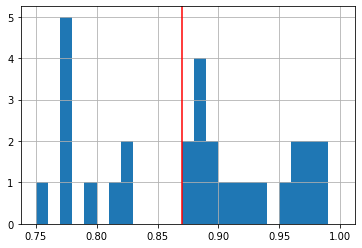

In [44]:
all_samples["on"]["daughters"].query("(e_candidate & preselect)")["score_event"].hist(
    range=(0.75, 1), bins=25
)
plt.axvline(x=cut_val, c="r")

In [46]:
Run3_good = [(15222, 177, 8886)]
Run1_good = [
    (5161, 8, 447),
    (5360, 0, 45),
    (5444, 1, 87),
    (5583, 13, 692),
    (5607, 15, 796),
    (5729, 121, 6086),
    (5197, 8, 412),
    (5924, 2, 109),
    (5904, 22, 1128),
    (5364, 114, 5740),
    (5326, 92, 4638),
]
q_all_good = "e_candidate & ("
for ev_good in Run1_good + Run3_good:
    q_all_good += "(run=={} & sub=={} & evt=={}) | ".format(*ev_good)

q_all_good = q_all_good[:-2] + ")"
print(q_all_good)
all_samples["on"]["daughters"].query(q_all_good)[
    [
        "run",
        "evt",
        "sub",
        "score",
        "score_event",
        "shr_energy_y_v",
        "shr_dist_v",
        "shr_tkfit_4cm_dedx_wm_v",
        "shr_tkfit_dedx_y_v",
        "shr_tkfit_2cm_dedx_Y",
        "shr_tkfit_gap10_dedx_y_v",
        "shr_moliere_avg_v",
        "shr_tkfit_hitratio_v",
        "shr_subclusters_v",
        "secondshower_Y_nhit",
        "contained_fraction",
        "n_showers_contained",
        "n_tracks_contained",
    ]
]

e_candidate & ((run==5161 & sub==8 & evt==447) | (run==5360 & sub==0 & evt==45) | (run==5444 & sub==1 & evt==87) | (run==5583 & sub==13 & evt==692) | (run==5607 & sub==15 & evt==796) | (run==5729 & sub==121 & evt==6086) | (run==5197 & sub==8 & evt==412) | (run==5924 & sub==2 & evt==109) | (run==5904 & sub==22 & evt==1128) | (run==5364 & sub==114 & evt==5740) | (run==5326 & sub==92 & evt==4638) | (run==15222 & sub==177 & evt==8886) )


run   evt  sub     score  score_event  \
sample Run event  daughter                                            
1      1   24627  0          5729  6086  121  0.889059     0.914777   
           33725  0          5364  5740  114  0.768728     0.931852   
           78004  0          5161   447    8  0.949668     0.977458   
           82766  0          5924   109    2  0.965601     0.965441   
           88438  0          5607   796   15  0.971672     0.977656   
           103099 0          5197   412    8  0.815708     0.888417   
           121542 0          5360    45    0  0.963039     0.880834   
           127754 0          5326  4638   92  0.572170     0.792501   
           140429 0          5904  1128   22  0.976275     0.988423   
           141172 0          5444    87    1  0.983844     0.986712   
       3   6311   0         15222  8886  177  0.759441     0.907114   

                            shr_energy_y_v  shr_dist_v  \
sample Run event  daughter                               
1      1   24627  0             828.802307    0.252549   
           33725  0             564.865784    0.887717   
           78004  0            1026.401855    0.196993   
           82766  0            2792.385254    2.679116   
           88438  0            2004.926147    1.354943   
           103099 0            1473.672974    0.564971   
           121542 0             484.984344    0.789450   
           127754 0             106.817375    0.925742   
           140429 0             478.747345    0.593165   
           141172 0            1146.877075    1.346684   
       3   6311   0             303.459595    3.650781   

                            shr_tkfit_4cm_dedx_wm_v  shr_tkfit_dedx_y_v  \
sample Run event  daughter                                                
1      1   24627  0                        2.333313            2.309928   
           33725  0                        7.646756            5.422145   
           78004  0                        1.586149            1.804561   
           82766  0                        3.334459            2.787252   
           88438  0                        3.795423            9.049864   
           103099 0                        4.431895            5.944706   
           121542 0                        1.612558            1.451203   
           127754 0                        2.149602            2.082618   
           140429 0                        1.947023            1.879645   
           141172 0                        5.480813            6.934304   
       3   6311   0                        2.019120            2.204308   

                            shr_tkfit_2cm_dedx_Y  shr_tkfit_gap10_dedx_y_v  \
sample Run event  daughter                                                   
1      1   24627  0                     2.705014                  2.052225   
           33725  0                     7.249501                  5.226874   
           78004  0                     1.770237                  1.804561   
           82766  0                     2.787222                  0.000000   
           88438  0                     1.598152                  5.694989   
           103099 0                     4.198626                  7.429641   
           121542 0                     1.451100                  0.000000   
           127754 0                     2.050381                  2.270621   
           140429 0                     1.834728                  1.850422   
           141172 0                     7.209081                  1.961730   
       3   6311   0                     1.921561                  2.135227   

                            shr_moliere_avg_v  shr_tkfit_hitratio_v  \
sample Run event  daughter                                            
1      1   24627  0                  6.119995              0.220381   
           33725  0                 11.169602              0.217914   
           78004  0                  5.482877              0.148681   
     

### Vertex specharge validation plot

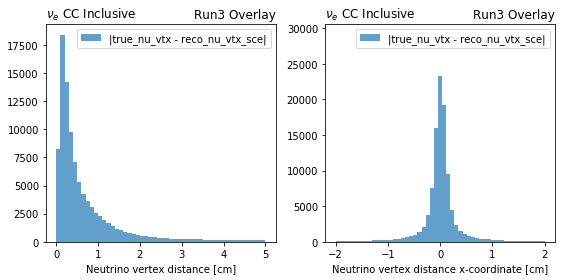

In [48]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))

ax[0].hist(
    all_samples["nu"]["daughters"]
    .query("nueccinc")["true_vtx_distance"]
    .xs(0, level="daughter"),
    bins=50,
    range=(0, 5),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)
ax[0].set_xlabel("Neutrino vertex distance [cm]")
ax[0].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[0].set_title("Run3 Overlay", loc="right")
ax[0].legend()

reco_nu_vtx_sce_x = (
    all_samples["nu"]["daughters"]
    .query("nueccinc")
    .xs(0, level="daughter")["reco_nu_vtx_sce_x"]
)
true_nu_vtx_x = all_samples["nu"]["mc"]["true_nu_vtx_x"][
    (all_samples["nu"]["mc"]["nueccinc"] > 0) & (all_samples["nu"]["mc"]["n_pfps"] > 0)
]
ax[1].hist(
    true_nu_vtx_x + nue_helper.x_sce_magic - reco_nu_vtx_sce_x,
    bins=51,
    range=(-2, 2),
    label="|true_nu_vtx - reco_nu_vtx_sce|",
    alpha=0.7,
)

ax[1].set_xlabel("Neutrino vertex distance x-coordinate [cm]")
ax[1].set_title(r"$\nu_e$ CC Inclusive", loc="left")
ax[1].set_title("Run3 Overlay", loc="right")
ax[1].set_ylim(0, ax[1].get_ylim()[1] * 1.25)
ax[1].legend()

fig.tight_layout()
fig.savefig(output_dir + "training/vtx_distance.pdf")